# Tarvel Review Ratings

Google reviews on attractions from 24 categories across Europe are considered. Google user rating ranges from 1 to 5 and average user rating per category is calculated.

## Goal

To predict how will user give a review to a location from other infomations.

## Attribute Information

For each attribute, the first is the unique id for each uesr. The others are how the user rating a category for a location on average

The values ranges from 0.00 to 5.00 actually, not 1.00 to 5.00 for it's original discription.

for detailed information for each attribute, please refer to this website: https://archive.ics.uci.edu/ml/datasets/Tarvel+Review+Ratings

I will rename the attribute later.

There are totally 5456 data

## Approaches

I will use the former 23 categories as feature, the last category is the thing I would used to cluster people alike

that is, the last category (gardens) is the goal we want to cluster people into several (maybe 6) groups

and how they rate the other 23 categories is the features to train.

However, the original value seems to be too discrete, I shall divide them into several parts

## Preprocessing



In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from sklearn import metrics, model_selection, svm

In [14]:
# loading file
filename = 'google_review_ratings.csv'
data = pd.read_csv(filename)
# there are \"Unnamed: 25\" colume somehow, it's NaN so it sould be dropped
# user ID is not needed here too, so drop it as well
data = data.drop(["User", "Unnamed: 25"],axis=1)
attributes = [
    'churches', 'resorts', 'beaches', 'parks', 'theatres', 'museums',
    'malls', 'zoo', 'restaurants', 'pubs/bars', 'local services', 'burger/pizza shops',
    'hotels/other lodgings', 'juice bars', 'art galleries', 'dance clubs', 'swimming pools', 'gyms', 
    'bakeries', 'beauty & spas', 'cafes', 'view points', 'monuments', 'gardens',
]
data.columns = attributes

# data = data.astype(np.float64)  # There are some columns are NOT float64, so I need to converte them
# I gave up, there are corrupted data in local service and I don't know how to fix it, so I just drop it
# I got error message: ValueError: could not convert string to float: '2\t2.'

data=data.drop(["local services"],axis=1)
data = data.astype(np.float64)

data.head()

,churches,resorts,beaches,parks,theatres,museums,malls,zoo,restaurants,pubs/bars,...,art galleries,dance clubs,swimming pools,gyms,bakeries,beauty & spas,cafes,view points,monuments,gardens
0,0.0,0.0,3.63,3.65,5.0,2.92,5.0,2.35,2.33,2.64,...,1.74,0.59,0.5,0.0,0.5,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,3.63,3.65,5.0,2.92,5.0,2.64,2.33,2.65,...,1.74,0.59,0.5,0.0,0.5,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,3.63,3.63,5.0,2.92,5.0,2.64,2.33,2.64,...,1.74,0.59,0.5,0.0,0.5,0.0,0.0,0.0,0.0,0.0
3,0.0,0.5,3.63,3.63,5.0,2.92,5.0,2.35,2.33,2.64,...,1.74,0.59,0.5,0.0,0.5,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,3.63,3.63,5.0,2.92,5.0,2.64,2.33,2.64,...,1.74,0.59,0.5,0.0,0.5,0.0,0.0,0.0,0.0,0.0


In [15]:
# I got value error while applying svm below, so I turn back to try to fix it
# ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

print('Is there any NaN?  {tf}'.format(tf=np.any(np.isnan(data))))
print('Is there any Inf?  {tf}'.format(tf=np.all(np.isfinite(data))))

data[np.isnan(data) == True] = 0

print('Is there any NaN? After fix? {tf}'.format(tf=np.any(np.isnan(data))))

# See if I fix it
# I think yes

Is there any NaN?  True
Is there any Inf?  False
Is there any NaN? After fix? False


In [16]:
# spliting dataset

# the graden is too discrete for SVM, see explaination for this apporach below
for i in range(len(data)):
    if data['gardens'][i] < 1.00:
        data['gardens'][i] = 0
    elif data['gardens'][i] > 1.00 and data['gardens'][i] < 2.00:
        data['gardens'][i] = 1
    elif data['gardens'][i] > 2.00 and data['gardens'][i] < 3.00:
        data['gardens'][i] = 2
    elif data['gardens'][i] > 3.00 and data['gardens'][i] < 4.00:
        data['gardens'][i] = 3
    elif data['gardens'][i] > 4.00 and data['gardens'][i] < 5.00:
        data['gardens'][i] = 4

np.random.seed(0) # use random seed to control spliting dataset to achieve reproducibility
train, test = model_selection.train_test_split(data) 
# test size is 0.25 by default and the rest is for training, not sure if I should change it

def split(data):
    x_data = data.loc[:, data.columns != 'gardens']
    y_data = data['gardens']
    return x_data, y_data

x_train, y_train = split(train)
x_test, y_test = split(test)

In [17]:
# evaluation function for training results
def evaluate(model, x_train, y_train, x_test, y_test):
    model.fit(x_train, y_train)

    train_predict = model.predict(x_train)
    test_predict = model.predict(x_test)

    train_acc = metrics.accuracy_score(y_train, train_predict)
    test_acc = metrics.accuracy_score(y_test, test_predict)

    return train_acc, test_acc

## Clustering

Using SVM to try to cluster people by the how they give rating to places.

Some categories are related to others, and people who loves a specific category would probably give high rating to places alike.

but first of all, we need to split them into 6 groups or we can't apply SVM

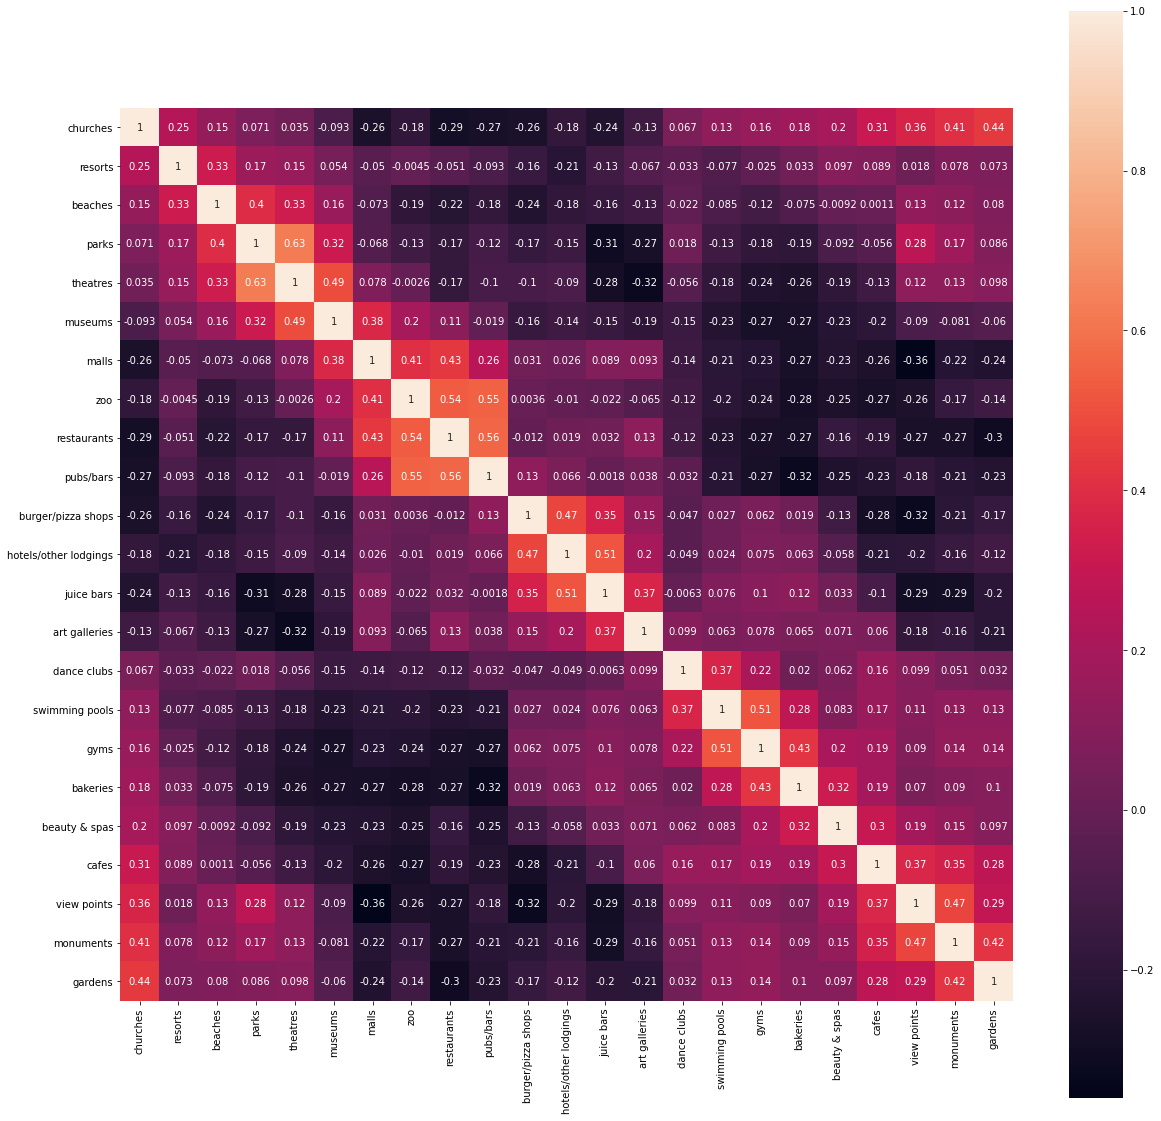

In [18]:
import seaborn as sb
plt.figure(figsize=(20,20))
heatmap = sb.heatmap(data.corr(), square=True, annot=True)
plt.show() # you can see there is correlations between each category

In [19]:
clf = svm.SVC(kernel='linear')
train_acc, test_acc = evaluate(clf, x_train, y_train, x_test, y_test)

print('----Linear kernel----')
print('Training accuracy: ' + str(train_acc))
print('Testing accuracy: ' + str(test_acc))

----Linear kernel----
Training accuracy: 0.8159824046920822
Testing accuracy: 0.8335777126099707


Though there are 80% acc. But maybe in this case, linear module is not really suitable

Trying out other kernels

In [20]:
clf = svm.SVC(kernel='poly')
train_acc, test_acc = evaluate(clf, x_train, y_train, x_test, y_test)

print('----Poly kernel----')
print('Training accuracy: ' + str(train_acc))
print('Testing accuracy: ' + str(test_acc))

----Poly kernel----
Training accuracy: 0.9098240469208211
Testing accuracy: 0.874633431085044


In [21]:
clf = svm.SVC(kernel='rbf')
train_acc, test_acc = evaluate(clf, x_train, y_train, x_test, y_test)

print('----rbf kernel----')
print('Training accuracy: ' + str(train_acc))
print('Testing accuracy: ' + str(test_acc))

----rbf kernel----
Training accuracy: 0.8707233626588465
Testing accuracy: 0.8687683284457478


we can see there is a lot of improvement on poly and rbf kernel

there are a lot of features to train. usually, with a lot of features, LR or linear kernel should perform better

however in this case, maybe the relation between features are not strongly related, and thus linear methods are not suitable in this case.

rbf kernel have high flexibility, so trying to adjust rbf kernel first

in rbf kernel, the regularization parameter (C) matters a lot

In [22]:
clf = svm.SVC(C=10, kernel="rbf")
train_acc, test_acc = evaluate(clf, x_train, y_train, x_test, y_test)

print('----rbf kernel with C = 10----')
print('Training accuracy: ' + str(train_acc))
print('Testing accuracy: ' + str(test_acc))

clf = svm.SVC(C=100, kernel="rbf")
train_acc, test_acc = evaluate(clf, x_train, y_train, x_test, y_test)

print('----rbf kernel with C = 100----')
print('Training accuracy: ' + str(train_acc))
print('Testing accuracy: ' + str(test_acc))

----rbf kernel with C = 10----
Training accuracy: 0.9286412512218963
Testing accuracy: 0.8878299120234604
----rbf kernel with C = 100----
Training accuracy: 0.9694525904203324
Testing accuracy: 0.8775659824046921


it perfroms better with C=10, and overfitted while C=100

another parameter that matters is gamma, and we can see it's better in both training and testing as we turn it into 'auto'

it's might because every features should affect equally the same,

when gamma is 'scale', the value will be: `1 / (n_features * X.var())`

In [23]:
clf = svm.SVC(C=10, kernel="rbf", gamma='auto')
train_acc, test_acc = evaluate(clf, x_train, y_train, x_test, y_test)

print('----rbf kernel with C = 10 and gamma is auto----')
print('Training accuracy: ' + str(train_acc))
print('Testing accuracy: ' + str(test_acc))

----rbf kernel with C = 10 and gamma is auto----
Training accuracy: 0.9543010752688172
Testing accuracy: 0.8922287390029325


now turn back to poly kernel, and trying to adjust some parameters

the degree of polynomial might be the most important, so adjust this first.

we can see degree of 4 might be the best, 5 will overfitting

what about rasing regularization parameter?

it seems that it will cause overfitting.

In [24]:
clf = svm.SVC(kernel='poly', degree=4)
train_acc, test_acc = evaluate(clf, x_train, y_train, x_test, y_test)

print('----Poly kernel with degree of 4----')
print('Training accuracy: ' + str(train_acc))
print('Testing accuracy: ' + str(test_acc))

clf = svm.SVC(kernel='poly', degree=5)
train_acc, test_acc = evaluate(clf, x_train, y_train, x_test, y_test)

print('----Poly kernel with degree of 5----')
print('Training accuracy: ' + str(train_acc))
print('Testing accuracy: ' + str(test_acc))

clf = svm.SVC(C=5, kernel='poly', degree=4)
train_acc, test_acc = evaluate(clf, x_train, y_train, x_test, y_test)

print('----Poly kernel with degree of 4 and C=5----')
print('Training accuracy: ' + str(train_acc))
print('Testing accuracy: ' + str(test_acc))

----Poly kernel with degree of 4----
Training accuracy: 0.9403714565004888
Testing accuracy: 0.8819648093841642
----Poly kernel with degree of 5----
Training accuracy: 0.9623655913978495
Testing accuracy: 0.8775659824046921
----Poly kernel with degree of 4 and C=5----
Training accuracy: 0.9633431085043989
Testing accuracy: 0.873900293255132


## Conclusion

in this case, it seems to be a non linear separable question to be solved

though linear kernel is not really bad, rbf might do the best while clustering this dataset

and might be useful when predict how will the user give rating to a place

generally, with a lot of features, linear kernel will be fast and accurate

rbf kernel will need some adjustments, and take much longer time for training

maybe 5000 pieces of data is not large enough to see the difference, but rbf might usually do the best regardless of time.

## References

- https://stackoverflow.com/questions/31323499/sklearn-error-valueerror-input-contains-nan-infinity-or-a-value-too-large-for

- https://kknews.cc/zh-tw/code/x6lmlar.html

- https://www.kdnuggets.com/2016/06/select-support-vector-machine-kernels.html

- https://zwindr.blogspot.com/2017/05/ml-kernel-svm.html

- https://www.zhihu.com/question/21883548

- https://stackoverflow.com/questions/40077432/why-is-scikit-learn-svm-svc-extremely-slow